# Testing K nearest neigbours

Using the features file to separate into labels and features

In [33]:
import pandas as pd
import numpy as np

data = pd.read_csv('./util/enhanced_feature_dataset.csv') 
data.fillna(0, inplace=True)
X = data[['border', 'asymmetry', 'mean_H', 'std_H', 'mean_H', 'mean_S', 'std_S', 'mean_V', 'std_V']]

data['cancer'] = data['cancer'].astype(int)
y = data['cancer']
groups = data['patient_id']
unique_patients = data['patient_id'].unique()

Running cross-validation over different k values (get AUC)

In [34]:
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

#split data into training and test sets (by patient ID)
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_idx = data['patient_id'].isin(train_ids)

X_train, y_train = X[train_idx], y[train_idx]
groups_train = groups[train_idx]

#standardScaler on training data (within pipeline below)
#GroupKFold CV with k from 3 to 10
cv = GroupKFold(n_splits=5)
k_values = range(1, 101, 2)
summary = []

for k in k_values:
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, groups=groups_train, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"k={k}, AUC={mean_auc:.4f} ± {std_auc:.4f}")
    summary.append({'k': k, 'mean_auc': mean_auc, 'std_auc': std_auc})

summary_df = pd.DataFrame(summary)

k=1, AUC=0.5859 ± 0.0180
k=3, AUC=0.6540 ± 0.0186
k=5, AUC=0.6636 ± 0.0193
k=7, AUC=0.6688 ± 0.0160
k=9, AUC=0.6757 ± 0.0179
k=11, AUC=0.6839 ± 0.0167
k=13, AUC=0.6881 ± 0.0151
k=15, AUC=0.6886 ± 0.0150
k=17, AUC=0.6879 ± 0.0177
k=19, AUC=0.6954 ± 0.0248
k=21, AUC=0.6967 ± 0.0257
k=23, AUC=0.6954 ± 0.0204
k=25, AUC=0.6919 ± 0.0227
k=27, AUC=0.6928 ± 0.0203
k=29, AUC=0.6897 ± 0.0213
k=31, AUC=0.6923 ± 0.0186
k=33, AUC=0.6909 ± 0.0180
k=35, AUC=0.6908 ± 0.0182
k=37, AUC=0.6918 ± 0.0187
k=39, AUC=0.6914 ± 0.0181
k=41, AUC=0.6934 ± 0.0171
k=43, AUC=0.6946 ± 0.0187
k=45, AUC=0.6976 ± 0.0198
k=47, AUC=0.6968 ± 0.0210
k=49, AUC=0.6959 ± 0.0197
k=51, AUC=0.6974 ± 0.0216
k=53, AUC=0.6992 ± 0.0204
k=55, AUC=0.7004 ± 0.0212
k=57, AUC=0.7032 ± 0.0204
k=59, AUC=0.7036 ± 0.0203
k=61, AUC=0.7034 ± 0.0210
k=63, AUC=0.7058 ± 0.0241
k=65, AUC=0.7051 ± 0.0232
k=67, AUC=0.7039 ± 0.0248
k=69, AUC=0.7048 ± 0.0256
k=71, AUC=0.7045 ± 0.0275
k=73, AUC=0.7050 ± 0.0267
k=75, AUC=0.7063 ± 0.0272
k=77, AUC=0.7056 

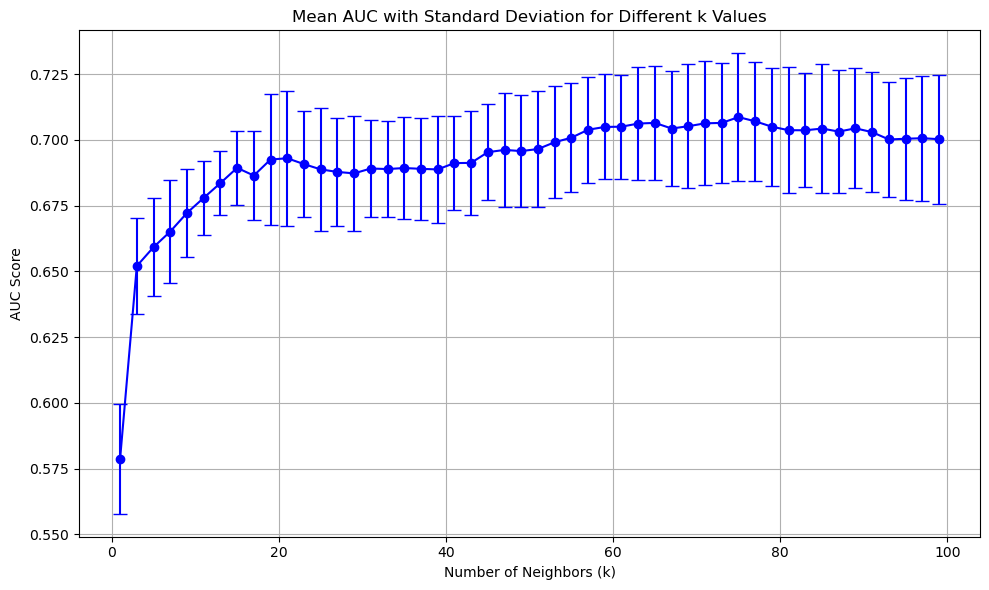

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.errorbar(summary_df['k'], summary_df['mean_auc'], yerr=summary_df['std_auc'], 
             fmt='-o', capsize=5, color='blue')
plt.title('Mean AUC with Standard Deviation for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Chosing k=25 to train the model

Final Evaluation on Test Set:
Accuracy: 0.6786
Recall: 0.6507
AUC: 0.7417
Precision: 0.7090
F1 Score: 0.6786


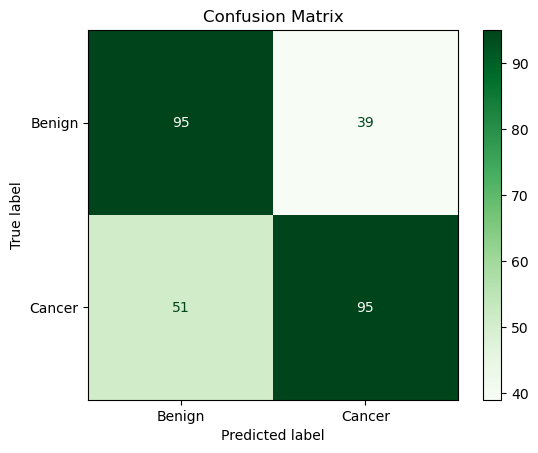

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Create test mask similar to train mask
test_mask = data['patient_id'].isin(test_ids)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_mask], y[test_mask]
groups_train = groups[train_idx]
patient_ids_test = groups[test_mask]

# Fit final model on training data (best k = 25)
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=25))
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probability of cancer

# Metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Final Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Benign", "Cancer"],
    cmap="Greens",
    values_format="d"
)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

results_df = pd.DataFrame({
    "patient_id": patient_ids_test.values,
    "true_label": y_test.values,
    "cancer_probability": y_prob
})

# results_df.to_csv("knn_final_test_probs.csv", index=False)

In [36]:
results_df[results_df['cancer_probability']>0.70].head(30)

,patient_id,true_label,cancer_probability
0,PAT_1017,0,0.80
8,PAT_1129,0,0.76
10,PAT_1153,0,0.80
19,PAT_120,1,0.76
20,PAT_121,1,0.76
36,PAT_1330,0,0.84
40,PAT_1392,0,0.92
46,PAT_1453,0,0.72
48,PAT_147,1,0.84
49,PAT_147,1,0.76


Checking features

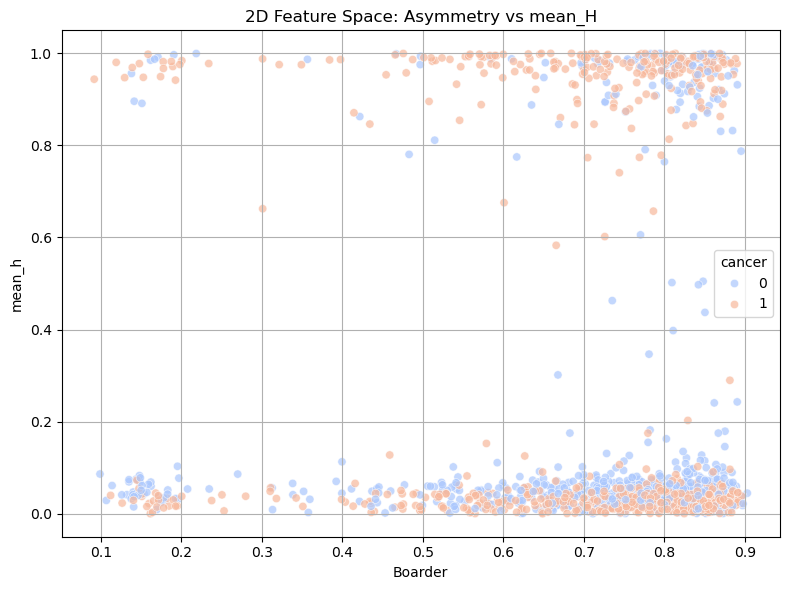

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data, 
    x='border', 
    y='mean_H', 
    hue='cancer', 
    palette='coolwarm', 
    alpha=0.7
)
plt.title("2D Feature Space: Asymmetry vs mean_H")
plt.xlabel("Boarder")
plt.ylabel("mean_h")
plt.grid(True)
plt.tight_layout()
plt.show()


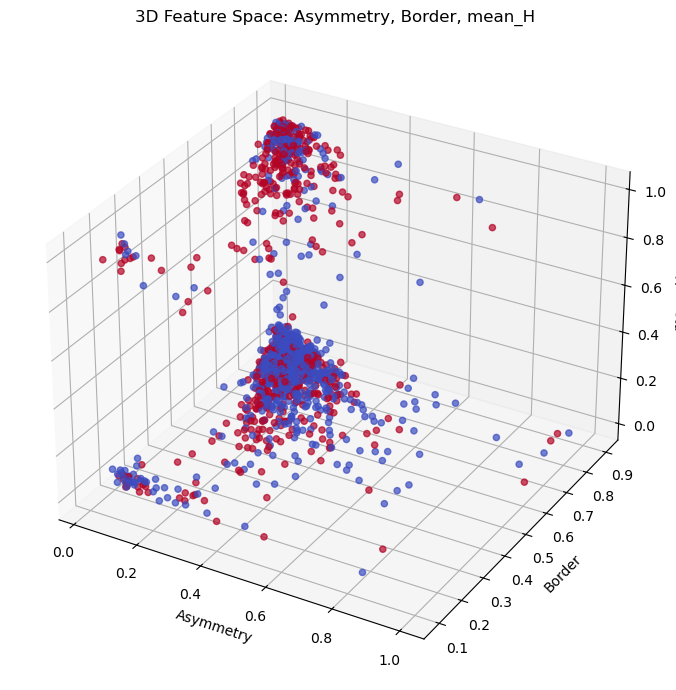

In [30]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(
    data['asymmetry'], 
    data['border'], 
    data['mean_H'], 
    c=data['cancer'], 
    cmap='coolwarm', 
    alpha=0.7
)

ax.set_title("3D Feature Space: Asymmetry, Border, mean_H")
ax.set_xlabel("Asymmetry")
ax.set_ylabel("Border")
ax.set_zlabel("mean_H")
plt.tight_layout()
plt.show()

## Patient Distribution

Total number of unique patients: 911
Average images per patient: 1.54
Max images per patient: 9
Min images per patient: 1


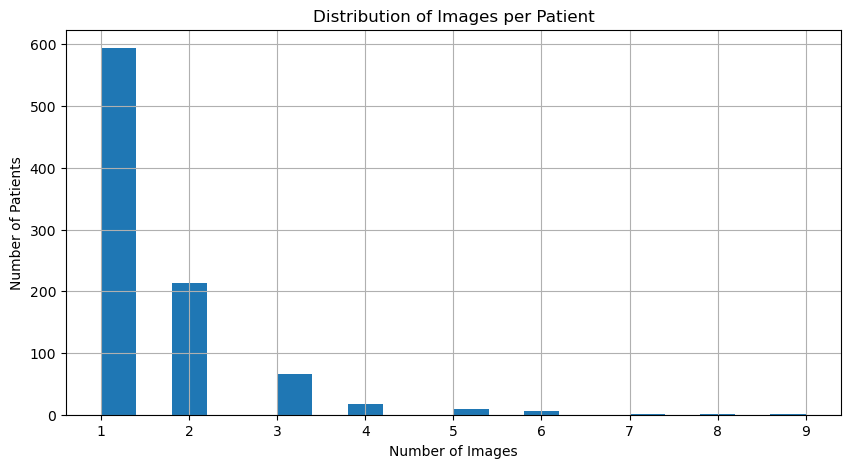

In [8]:
# Analyze patient distribution
patient_counts = data['patient_id'].value_counts()

print(f"Total number of unique patients: {len(patient_counts)}")
print(f"Average images per patient: {patient_counts.mean():.2f}")
print(f"Max images per patient: {patient_counts.max()}")
print(f"Min images per patient: {patient_counts.min()}")

# Show distribution of number of images per patient
plt.figure(figsize=(10, 5))
patient_counts.hist(bins=20)
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.show()

## Train-Test Split
function for keeping all images from a patient in one group

In [9]:
from sklearn.model_selection import train_test_split

# First, let's verify our split maintains patient separation
def verify_patient_split(train_ids, test_ids):
    intersection = set(train_ids) & set(test_ids)
    if len(intersection) > 0:
        print(f"Warning: {len(intersection)} patients appear in both sets!")
        return False
    return True

# Split patients into train and test sets
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Verify the split
is_valid_split = verify_patient_split(train_ids, test_ids)
print(f"Split is valid: {is_valid_split}")

# Create train and test masks
train_mask = data['patient_id'].isin(train_ids)
test_mask = data['patient_id'].isin(test_ids)

# Print split statistics
print(f"\nTraining set:")
print(f"Number of patients: {len(train_ids)}")
print(f"Number of images: {train_mask.sum()}")

print(f"\nTest set:")
print(f"Number of patients: {len(test_ids)}")
print(f"Number of images: {test_mask.sum()}")

# Create the actual split datasets
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
groups_train = groups[train_mask]

Split is valid: True

Training set:
Number of patients: 728
Number of images: 1122

Test set:
Number of patients: 183
Number of images: 280


# Decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


max_depth_values = range(1, 21) 
cv = GroupKFold(n_splits=5)

summary = []

for depth in max_depth_values:
    clf = make_pipeline(
        StandardScaler(),  # Optional for DecisionTree but included for consistency
        DecisionTreeClassifier(max_depth=depth, random_state=42)
    )

    auc_scores = cross_val_score(
        clf, X_train, y_train, cv=cv, groups=groups_train, scoring='roc_auc'
    )
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"max_depth={depth}, AUC={mean_auc:.4f} ± {std_auc:.4f}")
    summary.append({'max_depth': depth, 'mean_auc': mean_auc, 'std_auc': std_auc})

summary_df = pd.DataFrame(summary)


max_depth=1, AUC=0.5769 ± 0.0337
max_depth=2, AUC=0.6571 ± 0.0340
max_depth=3, AUC=0.6993 ± 0.0262
max_depth=4, AUC=0.7064 ± 0.0333
max_depth=5, AUC=0.6862 ± 0.0244
max_depth=6, AUC=0.6795 ± 0.0394
max_depth=7, AUC=0.6401 ± 0.0311
max_depth=8, AUC=0.6318 ± 0.0339
max_depth=9, AUC=0.6277 ± 0.0238
max_depth=10, AUC=0.6262 ± 0.0170
max_depth=11, AUC=0.6082 ± 0.0340
max_depth=12, AUC=0.6234 ± 0.0305
max_depth=13, AUC=0.6083 ± 0.0417
max_depth=14, AUC=0.6130 ± 0.0362
max_depth=15, AUC=0.6044 ± 0.0281
max_depth=16, AUC=0.6120 ± 0.0388
max_depth=17, AUC=0.6084 ± 0.0362
max_depth=18, AUC=0.6084 ± 0.0362
max_depth=19, AUC=0.6084 ± 0.0362
max_depth=20, AUC=0.6084 ± 0.0362


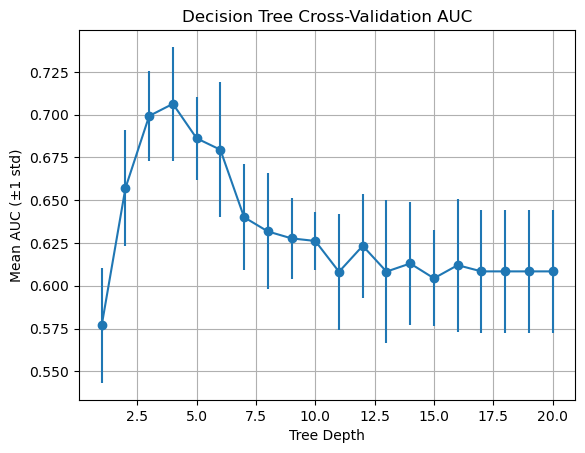

In [38]:
import matplotlib.pyplot as plt

plt.errorbar(summary_df['max_depth'], summary_df['mean_auc'], yerr=summary_df['std_auc'], fmt='-o')
plt.xlabel("Tree Depth")
plt.ylabel("Mean AUC (±1 std)")
plt.title("Decision Tree Cross-Validation AUC")
plt.grid(True)
plt.show()

Final Evaluation on Test Set (Decision Tree):
Accuracy:  0.7464
Recall:    0.7877
AUC:       0.7964
Precision: 0.7419
F1 Score:  0.7641


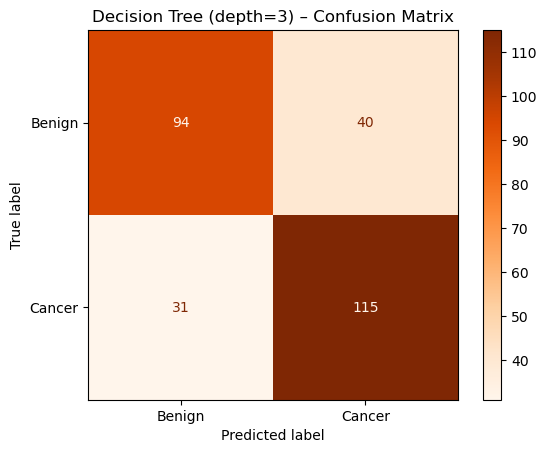

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, 
    precision_score, f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

# Use same data split
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_mask], y[test_mask]
patient_ids_test = groups[test_mask]

# Create pipeline with decision tree (depth=3)
pipe = make_pipeline(
    StandardScaler(),  # Optional for tree, included for consistency
    DecisionTreeClassifier(max_depth=4, random_state=42)
)

# Fit model
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

# Add predicted label to the results DataFrame
results_df = pd.DataFrame({
    "image": data['img_id'][test_mask].values,
    "patient_id": data['patient_id'][test_mask].values,
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "cancer_probability": y_prob
})

# Metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Final Evaluation on Test Set (Decision Tree):")
print(f"Accuracy:  {acc:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion matrix plot
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Benign", "Cancer"],
    cmap="Oranges",
    values_format="d"
)
plt.title("Decision Tree (depth=3) – Confusion Matrix")
plt.grid(False)
plt.show()

# results_df.to_csv("decision_tree_test_probs.csv", index=False)


In [46]:
false_negatives = results_df[
    (results_df["true_label"] == 1) & (results_df["predicted_label"] == 0)
]
false_negative_images = false_negatives["image"].tolist()
print(false_negative_images)


['PAT_109_868_113.png', 'PAT_143_213_489.png', 'PAT_172_266_950.png', 'PAT_208_314_741.png', 'PAT_247_1293_449.png', 'PAT_251_382_164.png', 'PAT_264_405_118.png', 'PAT_267_1062_418.png', 'PAT_268_413_643.png', 'PAT_313_669_908.png', 'PAT_313_669_935.png', 'PAT_320_681_410.png', 'PAT_320_681_724.png', 'PAT_321_682_236.png', 'PAT_323_687_169.png', 'PAT_363_746_18.png', 'PAT_369_756_130.png', 'PAT_406_808_975.png', 'PAT_406_809_581.png', 'PAT_452_882_896.png', 'PAT_460_894_429.png', 'PAT_506_957_377.png', 'PAT_550_1045_81.png', 'PAT_590_1121_504.png', 'PAT_605_1152_536.png', 'PAT_619_1175_767.png', 'PAT_645_1222_140.png', 'PAT_645_1223_124.png', 'PAT_76_1039_269.png', 'PAT_90_139_57.png', 'PAT_93_142_269.png']
